In [1]:
from arcgis.gis import GIS
import geopandas as gpd
import fiona
import json
import glob
import os
from arcgis import features as fs
import pdb

In [2]:
# Get a sorted list of all the project geopackages
prj_gpkgs = sorted(glob.glob("JornadaResearchProjects/*.gpkg"))

In [3]:
# Log into NMSU AGOL
import sys
sys.path.append('../')
import jgeo_py.agol as ag
import nmsu_agol_cred
agol_url=nmsu_agol_cred.agol_url
agol_user=nmsu_agol_cred.agol_user
password=nmsu_agol_cred.password
# Log into NMSU AGOL and get a GIS object
gis = GIS(agol_url, username=agol_user,
    password=password)

In [4]:
my_content = gis.content.search(query="owner:" + gis.users.me.username, 
                                item_type="Feature Layer", 
                                max_items=15)
my_content

[<Item title:"JER_CDRRC_Bdry_FromCorrectedMar2014" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"prj008" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"mongerunsam" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"WeatherStations" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"JERSoil1963" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"JRNLandforms2000" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"GigaPan_Camera_Loc" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"JornadaStudy_379_noaa_weather_station_climate_monthly?" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"Buffington_Herbel_1915" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"JornadaGeomorphology" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"Dirt_Tanks" type:Feature Layer Collection owner:gmaurer1>,
 <Item title:"Rds_ClipToJER_27Apr18" type:Feature Layer Collection owner:gmaurer1>,
 <Ite

epsg:4326
epsg:4326
epsg:4326
epsg:4326
epsg:4326


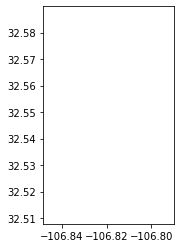

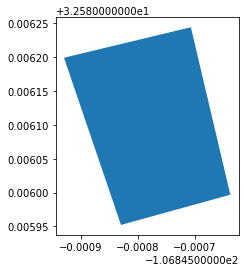

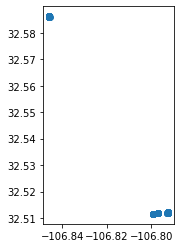

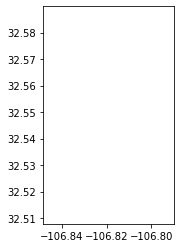

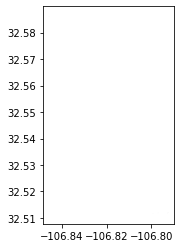

In [6]:
pkg = prj_gpkgs[0]
layers = fiona.listlayers(pkg)
for l in layers:
    gdf = gpd.read_file(pkg, layer=l)
    print(gdf.crs)
    gdf.plot()

In [7]:
# this adds a geopackage to AGOL - gpkgs are not that useful there
gis.content.add(data=pkg, item_properties={
    'type':'GeoPackage','title':'Jornada Hydrology Runoff Study exclosures',
                'description':'Location of exclosures',
                'tags':'Jornada Basin, hydrology, exclosure'})

Exception: Item 'prj001.gpkg' already exists.
(Error Code: 409)

In [60]:
# Try the data import
gdf_imp = gis.content.import_data(gdf)
# This fails because arcgis doesn't like GeoDataFrames

KeyError: 'MultiPolygon'

## Getting geodataframes from a local Geopackage into AGOL

In [9]:
pkg = prj_gpkgs[0]
tags = 'Jornada Basin, study 001, hydrology, research project'
description = 'Example demonstrating conversion of prj objects to an ArcGIS Online item or collection'
# These are the layers to add
layers = fiona.listlayers(pkg)

In [10]:
layers

['JornadaStudy_001_hydrology_runoff_drums',
 'JornadaStudy_001_hydrology_runoff_exclosures',
 'JornadaStudy_001_hydrology_runoff_gps_points',
 'JornadaStudy_001_hydrology_runoff_plates',
 'JornadaStudy_001_hydrology_runoff_plots']

In [213]:
# First try creating featureset from geojson derived from a geopandas dataframe'
gis.content.create_folder('JornadaResearchProjects_geojson_test1')
for i, l in enumerate(layers):
    gdf = gpd.read_file(pkg, layer=l)
    # You can convert the gdf to GeoJSON, then feature layer, then import
    gdf_json = gdf.to_json()
    gdf_json_dict = json.loads(gdf_json)
    # Use Arcgis to create a feature layer from the geojson
    fset=fs.FeatureSet.from_geojson(gdf_json_dict)
    # You could also use the GeoAccessor, but it sounds buggy
    #from arcgis.features import GeoAccessor
    #fset = GeoAccessor.from_geodataframe(gdf, inplace=False, column_name='SHAPE')
    #gdf_imp = gis.content.import_data(fset)
    
    # import data
    gdf_imp = gis.content.import_data(fset, folder='JornadaResearchProjects_geojson_test1')
    # update properties
    item_prop = {'type': 'GeoJson', 'description':description, 'title':l, 'tags':tags}
    gdf_imp.update(item_properties=item_prop)
        
# This works ok       

Folder already exists.


In [17]:
folder = 'JornadaResearchProjects/test2'
gis.content.create_folder(folder)

Folder already exists.


In [18]:
# Create a new folder on AGOL
folder = 'JornadaResearchProjects_test2'
gis.content.create_folder(folder)

for i, l in enumerate(layers):
    gdf = gpd.read_file(pkg, layer=l)
    lname = l + ".geojson"
    gdf.to_file(lname, driver='GeoJSON')
    
    item_prop = {'type': 'GeoJson', 'description':description, 'title':l, 'tags':tags}
    item = gis.content.add(item_prop, lname, folder=folder)
    item.publish(file_type='geojson')
    os.remove(lname)

# This works better

In [214]:
# This snippet may have some clues about setting access and such
# when you create the service

fgdb = r"C:\temp\foo.zip"

serviceProp = {}
serviceProp['type'] = 'File Geodatabase'
serviceProp['itemType'] = "file"
serviceProp['tags'] = "sometag"

pubProps = {}
pubProps["hasStaticData"] = 'true'
pubProps["name"] ="foo"
pubProps["maxRecordCount"] = 2000
pubProps["layerInfo"] = {"capabilities":"Query"}


fgdb1 = g.content.add(item_properties=serviceProp, data = fgdb)
print(fgdb1)
>><Item title:"foo" type:File Geodatabase owner:USER>

fgdb2 = fgdb1.publish(publish_parameters = pubProps, file_type = 'filegeodatabase', overwrite=True)
print(fgdb2)

SyntaxError: invalid syntax (3953676864.py, line 20)

In [164]:
# What I would like to do is create an empty feature service (aka
# featureLayerCollection) and then iterate through my project layers and 
# add them
empty_service_item = gis.content.create_service(name='prj001_test',
                                                service_type='featureService',
                                                folder='JornadaResearchProjects_testservice')
serv = gis.content.get(empty_service_item.id)
#And then do something like this to add each layer to the servide
gis.content.add(item_properties, dest = serv.layers[i])
# But I can't find the documentation for anything like this

In [17]:
folder = 'JornadaResearchProjects_servicetest'
gis.content.create_folder(folder)

new_service = gis.content.create_service(name='prj001_test',
                                         service_type='featureService',
                                         folder=folder)

newFtLC = fs.FeatureLayerCollection.fromitem(new_service)

dictUpdate = {"copyrightText": "copyrightText",
              "objectIdField" : "FID",
              "globalIdField" : "GlobalID",
              "maxRecordCount": 25000,
              "serviceDescription": "description",
              "capabilities": 'Editing,Query,Update,Uploads,Delete,Sync,Extract',
              "spatialReference": {"wkid": 4326,"latestWkid": 4326},
              "initialExtent":{
                   "xmax": 180.0,"ymin": -90.0,"xmin": -180.0,"ymax": 90.0, 
                   "spatialReference": {"wkid" : 4326, "latestWkid" : 4326}
                  },
              "fullExtent":{
                   "xmax": 180.0,"ymin": -90.0,"xmin": -180.0,"ymax": 90.0, 
                  "spatialReference": {"wkid" : 4326, "latestWkid" : 4326}
                  }
    }

newFtLC.manager.update_definition(dictUpdate)

layersList = []
dflist = []

for i, l in enumerate(layers):
    gdf = gpd.read_file(pkg, layer=l)
    lname = l + ".geojson"
    gdf.to_file(lname, driver='GeoJSON')
    
    item_prop = {'type': 'GeoJson', 'description':description, 'title':l, 'tags':tags}
    # Add item to AGOL in the given folder.
    item = gis.content.add(item_prop, lname, folder=folder)
    # Create feature layer to publish in newFtLC
    #ftly = fs.from_geojson(lname)
    newFtLC.upload(item)
    #layersList.append(item)
    #dflist.append(item)
    pdb.set_trace()
    
    #item.publish(file_type='geojson')
    os.remove(lname)
    
    
dictUpdate = {"layers": layersList }
newFtLC.manager.add_to_definition(dictUpdate)

def add_features(layer, featlist):
     result = layer.edit_features(adds = featlist)
     return result

for i in range(len(newFtLC.layers)):
     status = add_features(newFtLC.layers[i],
     dflist[i])
     print (status)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not Item

In [240]:
gis.content.delete_folder(folder)

True

In [241]:
# create a folder to test this stuff
folder = 'JornadaResearchProjects_servicetest2'
gis.content.create_folder(folder)

# Create a hosted feature service on AGOL
new_service = gis.content.create_service(name='prj001_test',
                                         service_type='featureService',
                                         folder=folder)
# Create a featureLayerCollection and assign some properties
newFtLC = fs.FeatureLayerCollection.fromitem(new_service)

dictUpdate = {"copyrightText": "copyrightText",
              "objectIdField" : "FID",
              "globalIdField" : "GlobalID",
              "maxRecordCount": 25000,
              "serviceDescription": "description",
              "capabilities": 'Editing,Query,Update,Uploads,Delete,Sync,Extract',
              "spatialReference": {"wkid": 4326,"latestWkid": 4326},
              "initialExtent":{
                   "xmax": 180.0,"ymin": -90.0,"xmin": -180.0,"ymax": 90.0, 
                   "spatialReference": {"wkid" : 4326, "latestWkid" : 4326}
                  },
              "fullExtent":{
                   "xmax": 180.0,"ymin": -90.0,"xmin": -180.0,"ymax": 90.0, 
                  "spatialReference": {"wkid" : 4326, "latestWkid" : 4326}
                  }
    }

newFtLC.manager.update_definition(dictUpdate)


def create_geojson_item(gpkg, layername, agol_layerprop, agol_folder):
    """ Put a geojson fiel on AGOL
    """
    gdf = gpd.read_file(gpkg, layer=layername)
    layer_fname = layername + '.geojson'
    gdf.to_file(layer_fname, driver='GeoJSON')
    # Add item to AGOL in the given folder.
    agol_item = gis.content.add(agol_layerprop, layer_fname, folder=agol_folder)
    os.remove(layer_fname)
    return(agol_item)
    
# Put a geojson on AGOL
item_prop = {'type': 'GeoJson', 'description':description, 'title':layers[0] + '2', 'tags':tags,
            'geometry':'polygon'}
item = create_geojson_item(pkg, layers[0], item_prop, folder)


    
    
#dictUpdate = {"layers": layersList }
#newFtLC.manager.add_to_definition(dictUpdate)

#def add_features(layer, featlist):
#     result = layer.edit_features(adds = featlist)
#     return result

#for i in range(len(newFtLC.layers)):
#     status = add_features(newFtLC.layers[i],
#     dflist[i])
#     print (status)

In [264]:
fl.properties

{
  "currentVersion": 10.81,
  "id": 0,
  "name": "JornadaStudy_001_hydrology_runoff_drums2_0",
  "type": "Feature Layer",
  "serviceItemId": "73053f45bb19463ea4a612f4fa7d0eaa",
  "cacheMaxAge": 30,
  "displayField": "",
  "description": "",
  "copyrightText": "",
  "defaultVisibility": true,
  "editingInfo": {
    "lastEditDate": 1640847514292
  },
  "relationships": [],
  "isDataVersioned": false,
  "hasContingentValuesDefinition": false,
  "supportsAppend": true,
  "supportsCalculate": true,
  "supportsASyncCalculate": true,
  "supportsTruncate": true,
  "supportsAttachmentsByUploadId": true,
  "supportsAttachmentsResizing": true,
  "supportsRollbackOnFailureParameter": true,
  "supportsStatistics": true,
  "supportsExceedsLimitStatistics": true,
  "supportsAdvancedQueries": true,
  "supportsValidateSql": true,
  "supportsCoordinatesQuantization": true,
  "supportsLayerOverrides": true,
  "supportsTilesAndBasicQueriesMode": true,
  "supportsFieldDescriptionProperty": true,
  "suppor

In [246]:
layersList = []
dflist = []

# Create feature layer to publish in newFtLC
item_s = item.publish(file_type='geojson')
fl = fs.FeatureLayer.fromitem(item_s)
#fl = fl.append(item_id=item.id, upload_format='GeoJSON')
#newFtLC.upload(item)
#layersList.append(item)
#dflist.append(item)

In [266]:
item_s

<Item title:"JornadaStudy_001_hydrology_runoff_drums2" type:Feature Layer Collection owner:gmaurer1>

In [229]:
fts = fs.GeoAccessor.from_layer(fl)

In [192]:
fts.spatial.area

19.0881235863655

<AxesSubplot:>

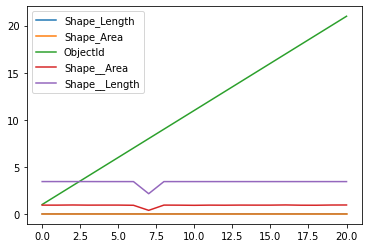

In [194]:
fts.plot()

In [265]:
fl.properties["tags"]

KeyError: 'tags'

In [230]:
dictLayer = {}
dictLayer["geometryType"] = fl.properties["geometryType"]
dictLayer["globalIdField"] = fl.properties["globalIdField"]
dictLayer["objectIdField"] = fl.properties["objectIdField"]
dictLayer["extent"] = fl.properties["extent"]
dictLayer["name"] = fl.properties["name"]
dictLayer["fields"] = fl.properties["fields"]

In [231]:
#fl_dict = fl.manager.properties
layersList.append(dictLayer)

dictUpdate = {"layers": layersList }
newFtLC.manager.add_to_definition(dictUpdate)
#item.publish(file_type='geojson')
#os.remove(lname)

{'success': True,
 'layers': [{'name': 'JornadaStudy_001_hydrology_runoff_drums2_0', 'id': 0}]}

In [232]:
dflist = []
dflist.append(fts)

In [234]:
# This seems to put the feature layer in the feature class, but not the data
#fl.container = newFtLC
item.id

'37dcc75f3a0745b594b0462800345325'

In [235]:
def add_features(layer, featlist):
    #result = layer.edit_features(adds = featlist)
    # Directly using the geojson item
    result = layer.append(item.id, upload_format='geojson', upsert=False)
    return result

for i in range(len(newFtLC.layers)):
     status = add_features(newFtLC.layers[i],
     dflist[i])
     print (status)

True


In [155]:
newFtLC.upload(fl.properties['serviceItemId'])

FileNotFoundError: [Errno 2] No such file or directory: '6de90bf738774a5bb8dacce588d328bb'